In [87]:
import timeit

import math
import fiona
import numpy as np
import osmnx as ox
import pandas as pd
import networkx as nx
import geopandas as gp
import matplotlib.pyplot as plt

from random import random
from queue import PriorityQueue
from shapely.ops import nearest_points
from shapely.geometry import Polygon,Point, MultiPoint, box
from skgeom import Point2,Segment2,arrangement,intersection,RotationalSweepVisibility, draw

%matplotlib inline

np.random.seed(27) # 21 for 1200 0.88

In [88]:
from QDalg import QDkMaximumVisibility
from QValg import QVkMaximumVisibility
from TDalg import TDkMaximumVisibility

from helpers import *

In [89]:
gdf = gp.read_file("datasets/obstacles1200.gpkg")
qpGdf = gp.read_file("datasets/querypoints1200.gpkg")

In [90]:

'''
    Visibility skgeom construction
'''
minx, miny, maxx, maxy = qpGdf.total_bounds*10000
minx-=10
miny-=10
maxx+=10
maxy+=10
outer = [
    Segment2(Point2(minx,miny), Point2(minx,maxy)), Segment2(Point2(minx,maxy), Point2(maxx,maxy)),
    Segment2(Point2(maxx,maxy), Point2(maxx,miny)), Segment2(Point2(maxx,miny), Point2(minx,miny))
]
arr = arrangement.Arrangement()
testAr = [arrangement.Arrangement() for _ in range(10)]
testAr2 = [arrangement.Arrangement() for _ in range(10)]

for bounds in outer:
    arr.insert(bounds)
    for i in range(10):
        testAr[i].insert(bounds)
        testAr2[i].insert(bounds)

Boundary = Polygon([(minx,miny),(minx,maxy),(maxx,maxy),(maxx,miny)])


In [91]:
'''
    Preprocessing our obstacle GeoDataFrame

        1. Simplifying building geometries
        2. Adding centroids
        x. Removing some obstacles randomly (not for prod?)
'''
gdf.drop(gdf[gdf['geometry'].type == 'Point'].index.values, inplace=True)
# envelope : convert to rectangles, simplify: reduce edges (also see shapely/geopandas docs)
simple = gdf['geometry'].convex_hull # REMOVING HOLES
simple = simple.simplify(0.5) # EDGE REDUCTION

# simple = gdf['geometry'].envelope # RECTANGLE APPROXIMATION ORIENTED WITH THE AXES
gdf['geometry'] = simple

# gdf = gdf.set_crs("EPSG:3035", allow_override=True)
gdf['centroid'] = gdf.centroid

gdf = gdf.sample(frac=0.3)
print(gdf.shape)

(699, 119)


In [92]:
'''
    Building TARGET.
'''
# Random Target
Target = gdf.sample(n=1)

# Specific Target
# Target = gdf.loc[gdf['name'] == 'Museum of Contemporary Art'] # comment frac.
print(Target)

gdf.drop(Target.index, inplace=True)

    element_type      osmid addr:state building    ele gnis:county_name  \
907          way  426250630       None      yes  124.8             None   

    gnis:feature_id gnis:import_uuid gnis:reviewed  name  ...  area  ways  \
907            None             None          None  None  ...  None  None   

     type   url building:height capacity theatre:genre  \
907  None  None            None     None          None   

    building:levels:underground  \
907                        None   

                                              geometry  \
907  POLYGON ((-118.26096 34.06133, -118.26106 34.0...   

                        centroid  
907  POINT (-118.26099 34.06139)  

[1 rows x 119 columns]


In [93]:
'''
    Inserting Target in our arrangement
'''
targetVx = Target.geometry.exterior.iloc[0].coords
targetBuilder = []

# [TODO] Build a duplicate checker since skgeom throws an error
for i in range(len(targetVx)-1):
    targetBuilder.append(Segment2(Point2(targetVx[i][0]*10000,targetVx[i][1]*10000), Point2(targetVx[i+1][0]*10000,targetVx[i+1][1]*10000)))

for bounds in targetBuilder:
    arr.insert(bounds)
    for i in range(10):
        testAr[i].insert(bounds)
        testAr2[i].insert(bounds)

targetPolyBuilder = []
for i in range(len(targetVx)-1):
    targetPolyBuilder.append(Point(targetVx[i][0]*10000,targetVx[i][1]*10000))

scaledTarget = Polygon(targetPolyBuilder)

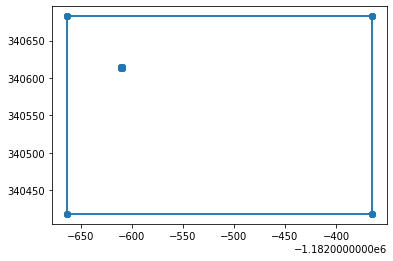

In [94]:
for he in arr.halfedges:
    draw.draw(he.curve())

In [95]:
treeNodes = []
for rtn in gdf.sindex.leaves():
    for rt in rtn[1]:
        treeNodes.append(rt)

print('No of obstacles:', len(treeNodes))

No of obstacles: 698


In [32]:
'''
0000000000000000000000000000000000000000000000000000000
'''

'\n0000000000000000000000000000000000000000000000000000000\n'

Time:  16.35215734800022
[7, 10, 0, 6, 13]
[0.931066, 0.873334, 0, 0, 0]
IO accesses:  798
Obs accesses:  99


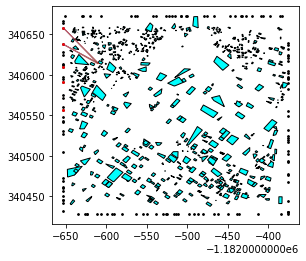

In [96]:
start = timeit.default_timer()
ans, ans_vis, ans_vrPoly, vrPolygons, IOcount, Obscount = QDkMaximumVisibility(targetBuilder,outer, qpGdf, 5, gdf,Boundary,treeNodes)
stop = timeit.default_timer()
print('Time: ', stop - start)
print(list(ans))
print(list(ans_vis))
print("IO accesses: ",IOcount)
print("Obs accesses: ",Obscount)
plotFinal(scaledTarget,gdf.sindex,gdf,qpGdf,vrPolygons,ans_vrPoly,ans)

Time:  17.59343654200029
[7, 10, 88, 12, 91]
[0.931066, 0.873334, 0, 0, 0]
IO accesses:  841
Obs accesses:  411


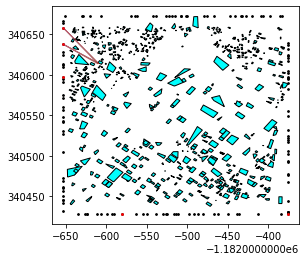

In [97]:
start = timeit.default_timer()
ans, ans_vis, ans_vrPoly, vrPolygons, IOcount, Obscount = QVkMaximumVisibility(targetBuilder,outer, qpGdf, 5, gdf,Boundary,treeNodes)
stop = timeit.default_timer()
print('Time: ', stop - start)
print(list(ans))
print(list(ans_vis))
print("IO accesses: ",IOcount)
print("Obs accesses: ",Obscount)
plotFinal(scaledTarget,gdf.sindex,gdf,qpGdf,vrPolygons,ans_vrPoly,ans)

Time:  23.025086788999943
[7, 10, 51, 94, 93]
[0.931066, 0.873334, 0, 0, 0]
IO accesses:  1754
Obs accesses:  699


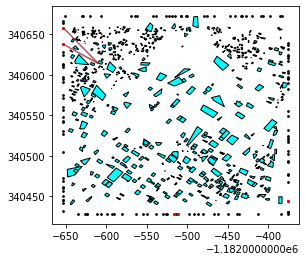

In [98]:
start = timeit.default_timer()
TDarr = arr
ans, ans_vis, ans_vrPoly, vrPolygons, IOcount, Obscount = TDkMaximumVisibility(targetBuilder, qpGdf, 5, gdf,scaledTarget,Boundary,TDarr)
stop = timeit.default_timer()
print('Time: ', stop - start)
print(list(ans))
print(list(ans_vis))
print("IO accesses: ",IOcount)
print("Obs accesses: ",Obscount)
plotFinal(scaledTarget,gdf.sindex,gdf,qpGdf,vrPolygons,ans_vrPoly,ans)

In [14]:
def experimentk(testAr):
    '''
        default qp, obs
    '''
    print('Varying k')
    qdio, qvio, tdio = [],[],[]
    qdobs, qvobs, tdobs = [],[],[]
    qdtime, qvtime, tdtime = [],[],[]


    qpGdfTest = qpGdf.sample(frac=0.25) # 32

    for pw in range(5):
        k = 2 ** pw
        print(k,".. ")
        TDx = [arr for _ in range(10)]
        print(len(list(testAr[pw].halfedges)))

        start = timeit.default_timer()
        ans, ans_vis, ans_vrPoly, vrPolygons, IOcount, Obscount = QDkMaximumVisibility(targetBuilder,outer, qpGdf, k, gdf,Boundary,treeNodes)
        stop = timeit.default_timer()
        qdio.append(IOcount)
        qdobs.append(Obscount)
        qdtime.append(stop-start)
        print ("QD \u2713")

        start = timeit.default_timer()
        ans, ans_vis, ans_vrPoly, vrPolygons, IOcount, Obscount = QVkMaximumVisibility(targetBuilder,outer, qpGdf, k, gdf,Boundary,treeNodes)
        stop = timeit.default_timer()
        qvio.append(IOcount)
        qvobs.append(Obscount)
        qvtime.append(stop-start)
        print ("QV \u2713")

        start = timeit.default_timer()
        ans, ans_vis, ans_vrPoly, vrPolygons, IOcount, Obscount = TDkMaximumVisibility(targetBuilder, qpGdf, k, gdf,scaledTarget,Boundary,testAr[pw])
        stop = timeit.default_timer()
        tdio.append(IOcount)
        tdobs.append(Obscount)
        tdtime.append(stop-start)
        print ("TD \u2713")

    return [qdio, qvio, tdio, qdobs, qvobs, tdobs, qdtime, qvtime, tdtime]

In [15]:
kResults = experimentk(testAr)

Varying k
1 .. 
16


In [44]:
kResults

[[5158, 5179, 5211, 5322, 5544],
 [5413, 5433, 5501, 5562, 5706],
 [7915, 7915, 7915, 8462, 8470],
 [123, 144, 175, 276, 456],
 [1975, 1975, 1975, 1975, 1975],
 [3802, 3803, 3805, 4961, 4969],
 [108.52994296899988,
  107.00542514599965,
  107.46453306000058,
  107.61723351700039,
  108.7903525519996],
 [112.53641887100002,
  112.44004397400022,
  113.34001117099979,
  113.44595605299946,
  113.83104644800005],
 [165.25631087500005,
  165.28989801999978,
  166.9838290000007,
  189.01533494999967,
  192.3085973520001]]

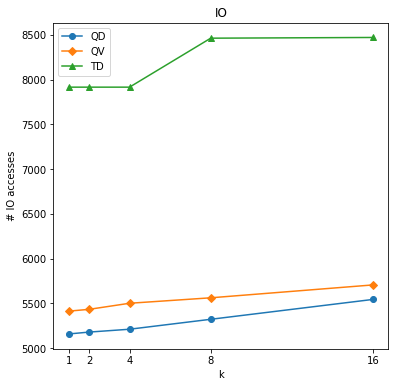

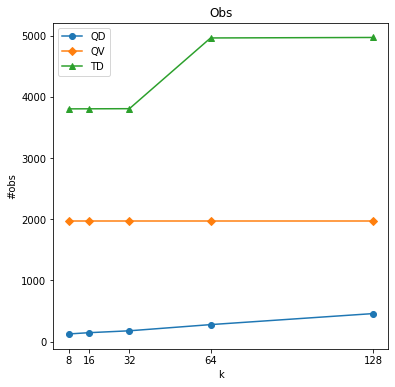

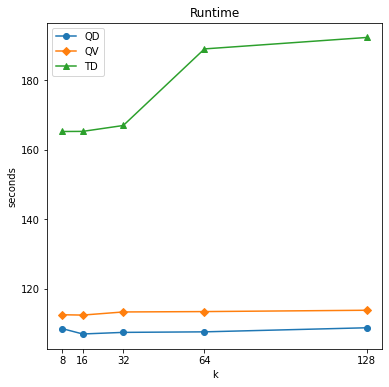

In [45]:
'''
    varying k
'''
x = [1,2,4,8,16]

# IO accesses
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x, kResults[0], label="QD", marker='o')
ax.plot(x, kResults[1], label="QV", marker='D')
ax.plot(x, kResults[2], label="TD", marker='^')

plt.title('IO')
plt.xticks(x)
plt.xlabel('k')
plt.ylabel('# IO accesses')
ax.legend()
plt.show()

x = [8,16,32,64,128]

# No. of Obstacles accessed
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x, kResults[3], label="QD", marker='o')
ax.plot(x, kResults[4], label="QV", marker='D')
ax.plot(x, kResults[5], label="TD", marker='^')

plt.title('Obs')
plt.xticks(x)
plt.xlabel('k')
plt.ylabel('#obs')
ax.legend()
plt.show()

x = [8,16,32,64,128]

# Runtime
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x, kResults[6], label="QD", marker='o')
ax.plot(x, kResults[7], label="QV", marker='D')
ax.plot(x, kResults[8], label="TD", marker='^')

plt.title('Runtime')
plt.xticks(x)
plt.xlabel('k')
plt.ylabel('seconds')
ax.legend()
plt.show()


In [46]:
def experimentQP(testAr2):
    '''
        default k, obs
        **Changed max bounds in .py files temporarily**
    '''
    print('Varying no. of query points')
    qdio, qvio, tdio = [],[],[]
    qdobs, qvobs, tdobs = [],[],[]
    qdtime, qvtime, tdtime = [],[],[]
    # TDx = [arr for _ in range(10)]

    for pw in range(3,8):
        qpn = 2 ** pw
        fraction = qpn / 128
        print(qpn,".. ")

        qpGdfTest = qpGdf.sample(frac=fraction)

        start = timeit.default_timer()
        ans, ans_vis, ans_vrPoly, vrPolygons, IOcount, Obscount = QDkMaximumVisibility(targetBuilder,outer, qpGdfTest, 4, gdf,Boundary,treeNodes)
        stop = timeit.default_timer()
        qdio.append(IOcount)
        qdobs.append(Obscount)
        qdtime.append(stop-start)
        print ("QD \u2713")

        start = timeit.default_timer()
        ans, ans_vis, ans_vrPoly, vrPolygons, IOcount, Obscount = QVkMaximumVisibility(targetBuilder,outer, qpGdfTest, 4, gdf,Boundary,treeNodes)
        stop = timeit.default_timer()
        qvio.append(IOcount)
        qvobs.append(Obscount)
        qvtime.append(stop-start)
        print ("QV \u2713")

        start = timeit.default_timer()
        ans, ans_vis, ans_vrPoly, vrPolygons, IOcount, Obscount = TDkMaximumVisibility(targetBuilder, qpGdfTest, 4, gdf,scaledTarget,Boundary,testAr2[pw])
        stop = timeit.default_timer()
        tdio.append(IOcount)
        tdobs.append(Obscount)
        tdtime.append(stop-start)
        print ("TD \u2713")

    return [qdio, qvio, tdio, qdobs, qvobs, tdobs, qdtime, qvtime, tdtime]

In [47]:
QPresults = experimentQP(testAr2)

Varying no. of query points
8 .. 
QD ✓
QV ✓
TD ✓
16 .. 
QD ✓
QV ✓
TD ✓
32 .. 
QD ✓
QV ✓
TD ✓
64 .. 
QD ✓
QV ✓
TD ✓
128 .. 
QD ✓
QV ✓
TD ✓


In [48]:
print(QPresults)

[[5142, 5168, 5160, 5179, 5211], [5152, 5230, 5252, 5419, 5501], [5238, 5464, 5724, 6844, 7915], [104, 132, 117, 144, 175], [201, 399, 682, 1281, 1975], [4254, 4390, 3805, 4961, 3805], [8.148691714000051, 14.497558862000005, 27.535907455000597, 53.24032063699997, 104.18845782799963], [8.544446659000641, 15.137308347999351, 28.551824609000505, 56.17943223999919, 109.0634031769996], [14.722903200000474, 24.100420533000033, 40.12325533500007, 88.62304771699928, 159.2719172240004]]


# Plotting

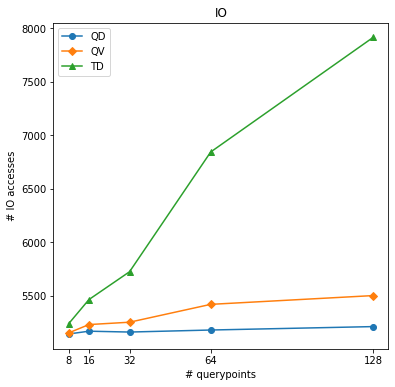

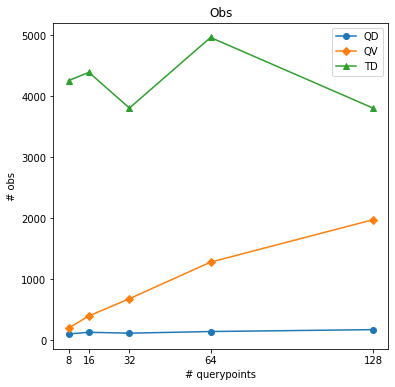

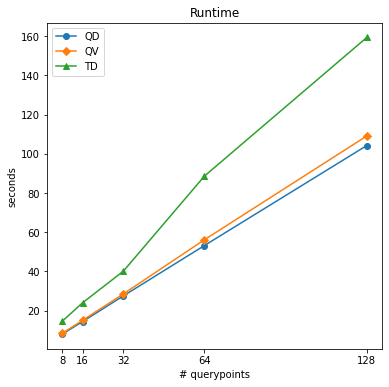

In [49]:
'''
    varying QPs
'''
x = [8,16,32,64,128]

# IO accesses
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x, QPresults[0], label="QD", marker='o')
ax.plot(x, QPresults[1], label="QV", marker='D')
ax.plot(x, QPresults[2], label="TD", marker='^')

plt.title('IO')
plt.xticks(x)
plt.xlabel('# querypoints')
plt.ylabel('# IO accesses')
ax.legend()
plt.show()

x = [8,16,32,64,128]

# No. of Obstacles accessed
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x, QPresults[3], label="QD", marker='o')
ax.plot(x, QPresults[4], label="QV", marker='D')
ax.plot(x, QPresults[5], label="TD", marker='^')

plt.title('Obs')
plt.xticks(x)
plt.xlabel('# querypoints')
plt.ylabel('# obs')
ax.legend()
plt.show()

x = [8,16,32,64,128]

# Runtime
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x, QPresults[6], label="QD", marker='o')
ax.plot(x, QPresults[7], label="QV", marker='D')
ax.plot(x, QPresults[8], label="TD", marker='^')

plt.title('Runtime')
plt.xticks(x)
plt.xlabel('# querypoints')
plt.ylabel('seconds')
ax.legend()
plt.show()


In [50]:
print ("TD \u2713")


TD ✓
